In [1]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv
import json
import numpy as np
import datetime

from sklearn.preprocessing import OneHotEncoder

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [2]:
load_dotenv()
opensea_api_key = os.getenv('OPENSEA_API_KEY')

# Data for Context and Analysis

### Collection Stats

In [ ]:
url = "https://api.opensea.io/api/v2/collections/pudgypenguins/stats"

headers = {
    "accept": "application/json",
    "x-api-key": opensea_api_key
}

response = requests.get(url, headers=headers)

collection_stats_response_json = response.json()

collection_totals_dict = collection_stats_response_json["total"]

# I had to set this index because there is not index and it was causing an error
# I used ChatGPT to debug this issue
collection_totals_df = pd.DataFrame(collection_totals_dict, index=[0])

collection_totals_df

,volume,sales,average_price,num_owners,market_cap,floor_price,floor_price_symbol
0,345832.218816,78951,4.38034,4776,102533.000618,11.557,ETH


## Trait Counts

In [ ]:
url = "https://api.opensea.io/api/v2/traits/pudgypenguins"

headers = {
    "accept": "application/json",
    "x-api-key": opensea_api_key
}

response = requests.get(url, headers=headers)

# Formatting as json
traits_json = response.json()

# get the "counts" and not "categories" key
traits_json = traits_json.get("counts", [])

# preview
traits_json

{'Background': {'Beige': 1152,
  'Blue': 1587,
  'Mint': 1389,
  'Red': 755,
  'Tangerine': 1135,
  'Yellow': 873,
  'Pink': 710,
  'Purple': 1282,
  'On The Beach': 1,
  'Supermarket': 1,
  'Green': 1,
  'Trick Or Treating': 1,
  'Underwater': 1},
 'Skin': {'Light Gray': 1189,
  'Mint': 423,
  'Maroon': 731,
  'Normal': 2649,
  'Leopard Pink': 89,
  'Dark Gray': 1329,
  'Baby Pink': 623,
  'Cream': 646,
  'Olive Green': 705,
  'Red': 344,
  'Gold': 44,
  'Leopard Gray': 89,
  'Ice': 22,
  'Navy Blue': 4,
  'Black': 1},
 'Body': {'Vote 4 Pudgy': 203,
  'Kimono Blue': 108,
  'Scarf Blue': 237,
  'Shirt Blue': 290,
  'Fish Lover': 70,
  'Turtleneck Grey': 210,
  'Lei Pink': 168,
  'Bow Tie Blue': 154,
  'Tank Top Yellow': 193,
  'Puffer Orange': 158,
  'Huddle Shirt': 228,
  'Kimono Brown': 268,
  'Lei Assorted': 76,
  'Bronze Medal': 193,
  'Gold Medal': 58,
  'Heart': 102,
  'Turtleneck Green': 254,
  'Scarf Pink': 177,
  'Surfboard Necklace': 166,
  'Swordman': 62,
  'Christmas Sweate

#### All Traits

In [ ]:
# df of all traits
# documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html
# similar to how OneHotEncoder creates new column names
traits_df_normalized = pd.json_normalize(traits_json)

traits_df_normalized

,Background.Beige,Background.Blue,Background.Mint,Background.Red,Background.Tangerine,Background.Yellow,Background.Pink,Background.Purple,Background.On The Beach,Background.Supermarket,...,Head.Sideways Red,Head.Egg Gold,Head.Flower Crown,Head.Fish Orange,Head.Ice Crown,Head.Hatched Gold,Head.Pineapple Suit,Head.Banana Suit,Head.Normal,Head.Shark Suit
0,1152,1587,1389,755,1135,873,710,1282,1,1,...,90,45,66,44,14,9,1,1,1,1


#### Isolating Traits

In [ ]:
# show all trait keys
traits_json.keys()

dict_keys(['Background', 'Skin', 'Body', 'Face', 'Head'])

In [ ]:
# explode the df
traits_df_exploded =  pd.DataFrame(traits_json)
traits_df_exploded = traits_df_exploded.explode("Background")

# create new dfs for each trait, sorted by values
# if you don't do reset_index(drop=True), it appears as a series
background_trait_df = traits_df_exploded["Background"].dropna().sort_values(ascending=False).reset_index()
skin_trait_df = traits_df_exploded["Skin"].dropna().sort_values(ascending=False).reset_index()
body_trait_df = traits_df_exploded["Body"].dropna().sort_values(ascending=False).reset_index()
face_trait_df = traits_df_exploded["Face"].dropna().sort_values(ascending=False).reset_index()
head_trait_df = traits_df_exploded["Head"].dropna().sort_values(ascending=False).reset_index()

# rename columns and set indices
background_trait_df = background_trait_df.rename(columns={"index":"background", "Background":"count"}).set_index("background")
skin_trait_df = skin_trait_df.rename(columns={"index":"skin", "Skin":"count"}).set_index("skin")
body_trait_df = body_trait_df.rename(columns={"index":"body", "Body":"count"}).set_index("body")
face_trait_df = face_trait_df.rename(columns={"index":"face", "Face":"count"}).set_index("face")
head_trait_df = head_trait_df.rename(columns={"index":"head", "Head":"count"}).set_index("head")

# display trait dataframes
display(background_trait_df, skin_trait_df, body_trait_df, face_trait_df, head_trait_df)

,count
background,
Blue,1587.0
Mint,1389.0
Purple,1282.0
Beige,1152.0
Tangerine,1135.0
Yellow,873.0
Red,755.0
Pink,710.0
On The Beach,1.0


,count
skin,
Normal,2649.0
Dark Gray,1329.0
Light Gray,1189.0
Maroon,731.0
Olive Green,705.0
Cream,646.0
Baby Pink,623.0
Mint,423.0
Red,344.0


,count
body,
Shirt Blue,290.0
Kimono Brown,268.0
Shirt Red,259.0
Turtleneck Green,254.0
Scarf Green,250.0
...,...
Pineapple Suit,1.0
Banana Suit,1.0
Mirrored,1.0


,count
face,
Winking,961.0
Blushing,932.0
Normal,864.0
Circle Glasses,768.0
Cute,588.0
Monocle,496.0
Squad,445.0
Eyepatch,426.0
Cross Eyed,417.0


,count
head,
Headband,357.0
Flat Cap Blue,355.0
Bucket Hat Green,349.0
Backwards Hat Red,294.0
Hat Blue,286.0
Top Hat,282.0
Hat Red,279.0
Beanie Orange,276.0
Flat Cap Tan,274.0


# Data for Model

## Sales Sample (50) "Events"

In [ ]:
# Set today's date
today = datetime.datetime.now()

# set number of days in past
past_date = today - datetime.timedelta(days=30)

# Convert to unix (starting 1970!)
unix_past_date = int(past_date.timestamp())

# Create blank df to store page data
events_df = pd.DataFrame()

# Initialize next_event variable
next_event = None

while True:
    url = f"https://api.opensea.io/api/v2/events/collection/pudgypenguins?after={unix_past_date}&event_type=sale"
    if next_event:
        # This adds the next event value (and required syntax) to the URL string
        url += f"&next={next_event}"

    headers = {
        "accept": "application/json",
        "x-api-key": opensea_api_key
    }

    response = requests.get(url, headers=headers)

    # Formatting as json
    events_json = response.json()

    # Get the "asset events"
    events_data = events_json.get("asset_events", [])
    
    # Store to df
    page_events_df = pd.json_normalize(events_data)
    
    # Concatenate to master df
    events_df = pd.concat([events_df, page_events_df], ignore_index=True)
    
    # Update next_event for pagination
    next_event = events_json.get("next")

    # If there are no more pages, exit the loop
    if not next_event:
        break

# preview
events_df

,event_type,order_hash,chain,protocol_address,closing_date,quantity,seller,buyer,transaction,event_timestamp,...,nft.image_url,nft.metadata_url,nft.opensea_url,nft.updated_at,nft.is_disabled,nft.is_nsfw,payment.quantity,payment.token_address,payment.decimals,payment.symbol
0,sale,,ethereum,,1714417763,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0xa69833b9fda816f1bfc79517e7932e64708df0dd,0x89baf7c352ab3288f966bc18741941635f4402a34fd3...,1714417763,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-04-29T19:09:26.292663,False,False,11060000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
1,sale,,ethereum,,1714417763,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0x13747adca0ce7e7f6aa661718a07e4c74e62ed19,0xaf39af775ce24f1a768658c7ef6fdf451354a260f5ab...,1714417763,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-04-29T19:09:26.274697,False,False,11060000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
2,sale,,ethereum,,1714413551,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0x458dbf62e68463fe0b14c0f8dd69e695d23ca0cb,0x4829b82409ba06c652e572a852518957c11ba28d00aa...,1714413551,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-04-29T17:59:14.361366,False,False,11000000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
3,sale,,ethereum,,1714413539,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0xa69833b9fda816f1bfc79517e7932e64708df0dd,0x089d37c0aee44bf4e5916a661324417293431af23f05...,1714413539,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-04-29T19:09:26.274697,False,False,11000000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
4,sale,,ethereum,,1714405895,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0x458dbf62e68463fe0b14c0f8dd69e695d23ca0cb,0x2cb10bc67223642698383c7245763830272df45754a5...,1714405895,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-04-29T15:51:38.163165,False,False,11060000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,sale,,ethereum,,1711885283,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0x5f1ee29361206f1a129e808736f11598356c6031,0xf8145f20599c91e5522955858959cf405e7ee231245d...,1711885283,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-03-31T13:14:50.078664,False,False,13960000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
1500,sale,,ethereum,,1711885259,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0x5f1ee29361206f1a129e808736f11598356c6031,0xa104fede5df7ac8c338aaa98daad92406a2b23d3253d...,1711885259,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-04-04T16:48:38.277911,False,False,13970000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
1501,sale,,ethereum,,1711875635,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0x31d5248020ff8e35f5cce912e3d8ec446db51b5c,0x52ac5cf8f0345535e8f87e1a0d2b57b506814f9e11d6...,1711875635,...,https://ipfs.io/ipfs/QmNf1UsmdGaMbpatQ6toXSkzD...,https://ipfs.io/ipfs/bafybeibc5sgo2plmjkq2tzmh...,https://opensea.io/assets/ethereum/0xbd3531da5...,2024-04-02T10:02:14.644853,False,False,14000000000000000000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,18,WETH
1502,sale,,ethereum,,1711871015,1,0x29469395eaf6f95920e59f858042f0e28d98a20b,0xa69833

### Individual NFT Info

#### query parameters from https://docs.opensea.io/reference/get_nft

In [ ]:
# PATH PARAMETERS

# note: nft contract is the same for the whole collection

# identify nft contract (public blockchain address)
# this creates an array
protocol_address = events_df["nft.contract"].unique()

# eliminate the null by getting the max of the array
protocol_address = np.max(protocol_address)

# find unique values for chain (currency)
chain = events_df["chain"].unique().tolist()

# write value without list
chain = chain[0]

# token ID in a list for iteration
token_id_list = events_df["nft.identifier"].drop_duplicates().to_list()

In [ ]:
# parsing features function
# credit: Sean!

def get_features (nft):
    features = {}
    features["Background"] = nft["traits"][0]["value"]
    features["Skin"] = nft["traits"][1]["value"]
    features["Face"] = nft["traits"][2]["value"]
    features["Head"] = nft["traits"][3]["value"]
    features["Body"] = nft["traits"][4]["value"]
    features["Rarity"] = nft["rarity"]["rank"]
    
    return features

In [ ]:
nfts_dict = {}
token_id = token_id_list[0]

for token_id in token_id_list:
    url = f"https://api.opensea.io/api/v2/chain/{chain}/contract/{protocol_address}/nfts/{token_id}"
    headers = {
        "accept": "application/json",
        "x-api-key": opensea_api_key
    }

    response = requests.get(url, headers=headers)

    # Formatting as json
    nfts_json = response.json()
    
    nfts_dict[token_id] = get_features(nfts_json["nft"])

In [ ]:
nfts_dict

nfts_df = pd.DataFrame(nfts_dict).transpose()

nfts_df

,Background,Skin,Face,Head,Body,Rarity
1167,Blue,Cute,Durag Blue,Baby Pink,Hawaiian Shirt,4663
5277,Light Gray,Beard,Pink,Turtleneck Green,Cowboy Hat,3623
1266,Blue,Normal,Turtleneck Grey,Eyepatch,Camo Helmet,7978
6062,Yellow,Cream,Clout Goggles,Camo Helmet,Ice Coat,1231
8852,Fish Lover,Backwards Hat Red,Purple,Red,Monocle,917
...,...,...,...,...,...,...
4494,Mint,Cute,Tangerine,Fish Green,Turtleneck Pink,1267
6997,Light Gray,Blue,Scarf Green,Hat Red,Monocle,7306
2009,Light Gray,Yellow,Huddle Shirt,Circle Glasses,Party Hat,5712
2485,Kimono Blue,Santa Hat,Dark Gray,Purple,Goggles,1577


In [ ]:
combined_events_df = events_df[["nft.identifier", "closing_date", "payment.quantity"]]

combined_events_df.set_index("nft.identifier", inplace=True)

combined_events_df

,closing_date,payment.quantity
nft.identifier,,
1167,1714417763,11060000000000000000
5277,1714417763,11060000000000000000
1266,1714413551,11000000000000000000
5277,1714413539,11000000000000000000
6062,1714405895,11060000000000000000
...,...,...
1091,1711885283,13960000000000000000
2511,1711885259,13970000000000000000
166,1711875635,14000000000000000000


In [ ]:
combined_df = combined_events_df.merge(nfts_df, how="outer", right_index=True, left_index=True)

combined_df

,closing_date,payment.quantity,Background,Skin,Face,Head,Body,Rarity
nft.identifier,,,,,,,,
1033,1713053207,11200000000000000000,Winking,Normal,Tangerine,None,Shirt Red,8741
1049,1714367927,11910000000000000000,Light Gray,Normal,Tangerine,Hat Blue,Puffer Green,6938
1073,1714226351,11760000000000000000,Normal,Cute,Tangerine,Hoodie Black,Macaroni,7702
1073,1714200911,11880000000000000000,Normal,Cute,Tangerine,Hoodie Black,Macaroni,7702
1073,1714144895,12010000000000000000,Normal,Cute,Tangerine,Hoodie Black,Macaroni,7702
...,...,...,...,...,...,...,...,...
956,1712232575,11470000000000000000,Mint,Mint,Scar,Afro With Pick,Lei Blue,1602
985,1713162587,10090000000000000000,Maroon,Mint,Cute,Hat Blue,Christmas Sweater Blue,3235
985,1713142367,10360000000000000000,Maroon,Mint,Cute,Hat Blue,Christmas Sweater Blue,3235


# ANVITHA

INSTRUCTIONS: We need a USD price instead of that Wei price for that exact UNIX date in the combined_df.

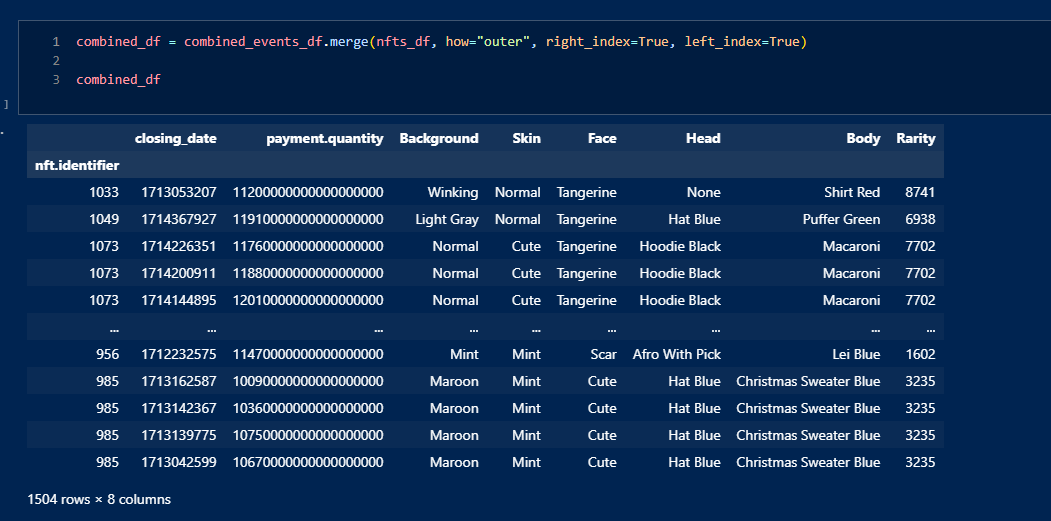

## ETH-USD Conversion

In [ ]:
def convert_usd_to_eth(usd_amount):
    # API URL for getting the latest ETH price in USD
    url = "https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        # Getting the current price of 1 ETH in USD
        eth_price = data['ethereum']['usd']
        
        # Calculating the amount in ETH
        eth_amount = usd_amount / eth_price
        
        return eth_amount
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example: Convert 100 USD to ETH
usd_amount = 100
eth_amount = convert_usd_to_eth(usd_amount)
eth_amount